## igraph-CX experiments

In [2]:
import ndex2
import matplotlib.pyplot as plt
import igraph
%matplotlib inline


## Get a test network from NDEx

In [3]:
NETWORK_UUID = "cfd3528f-a7a4-11eb-9e72-0ac135e8bacf"
SERVER = "https://ndexbio.org"
test_network = ndex2.create_nice_cx_from_server(SERVER, uuid=NETWORK_UUID)
test_network.print_summary()

Name: Sonic Hedgehog
Nodes: 18
Edges: 45
Node Attributes: 36
Edge Attributes: 450



## Make an igraph Graph object from the NiceCX object
- make a Graph with the same number of nodes
- set the Graph attributes to the CX network attributes
- iterate over the CX node list, incrementing the node index for the Graph
 - set a special "cx_id" attribute with the CX permanent ID
 - set the other node attributes to the CX node attributes
 - *right now,* I rely on Python default type assignment, not looking at the CX type declaration
- iterate over the CX edge list, incrementing an index for the Graph edge.
 - find the Graph node ids for the source and target CX ids 
 - add an edge to the Graph and set its attributes
 - get the CX style aspect and add it to the Graph as a network attribute
 - TODO: add the other opaque aspects, especially the style aspect
 
## TODO: CX2
Maybe optimization of this function to (1) avoid making a NiceCX object and (2) use streaming could wait for CX2.


In [4]:
def igraph_from_nice_cx(nice_cx):
    g = igraph.Graph(len(nice_cx.get_nodes()))
    # network attributes
    for name in nice_cx.get_network_attribute_names():
        value = nice_cx.get_network_attribute(name)["v"]
        #print(value)
        g[name]=value      
    # nodes and attributes and coordinates
    # make a node_id list
    node_id_list = []
    n_id = 0
    for node_id, node in nice_cx.get_nodes():
        g.vs[n_id]["cx_id"] = node_id
        if node.get("n"):
            g.vs[n_id]["name"] = node["n"]
        if node.get("r"):
            g.vs[n_id]["represents"] = node["r"]
        atts = nice_cx.get_node_attributes(node_id)
        for att in atts:
            att_name = att["n"]
            att_value = att["v"]
            g.vs[n_id][att_name] = att_value
        n_id += 1
        
    # edges and attributes
    for edge_id, edge in nice_cx.get_edges():
        cx_source_id = edge["s"]
        cx_target_id = edge["t"]
        g_source = g.vs.find(cx_id=cx_source_id)
        g_target = g.vs.find(cx_id=cx_target_id)
        g.add_edges([(g_source, g_target)])
        e_id = g.get_eid(g_source, g_target)
        g.es[e_id]["cx_id"] = edge_id
        atts = nice_cx.get_edge_attributes(node_id)
        for att in atts:
            att_name = att["n"]
            att_value = att["v"]
            g.es[e_id][att_name] = att_value

    # cartesian coordinates
    g["cartesian_layout"] = nice_cx.get_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT)
    #visual styles
    # bypasses
    # rules
    return g
   

In [5]:
g = igraph_from_nice_cx(test_network)
igraph.summary(g)
for v in g.vs:
    print(v)

IGRAPH UN-T 18 45 -- Sonic Hedgehog
+ attr: @context (g), __normalizationversion (g), cartesian_layout (g), description (g), labels (g), name (g), networkType (g), organism (g), prov:wasDerivedFrom (g), prov:wasGeneratedBy (g), reference (g), rights (g), rightsHolder (g), version (g), cx_id (v), location (v), name (v), represents (v), type (v), annotator (e), cell_data (e), citation (e), cx_id (e), direct (e), mechanism (e), notes (e), residue (e), sentence (e), sequence (e), tissue_data (e)
igraph.Vertex(<igraph.Graph object at 0x11cbdc040>, 0, {'cx_id': 0, 'name': 'GLI1', 'represents': 'uniprot:P08151', 'type': 'protein', 'location': 'factor'})
igraph.Vertex(<igraph.Graph object at 0x11cbdc040>, 1, {'cx_id': 1, 'name': 'Cell_growth', 'represents': 'signor:SIGNOR-PH33', 'type': 'phenotype', 'location': ''})
igraph.Vertex(<igraph.Graph object at 0x11cbdc040>, 2, {'cx_id': 2, 'name': 'ADCY1', 'represents': 'uniprot:Q08828', 'type': 'protein', 'location': 'receptor'})
igraph.Vertex(<igra

## Each time you plot, you have to create a fresh layout

In [15]:
def igraph_layout_from_cx_cartesian_layout(g):
    cx_layout = g["cartesian_layout"]
    igraph_layout = [(0,0)] * len(g.vs)
    for node in cx_layout:
        igraph_id = g.vs.find(node["node"]).index
        igraph_layout[igraph_id] = (node["x"],node["y"])
    return igraph.Layout(igraph_layout)

l = igraph_layout_from_cx_cartesian_layout(g)
l

<Layout with 18 vertices and 2 dimensions>

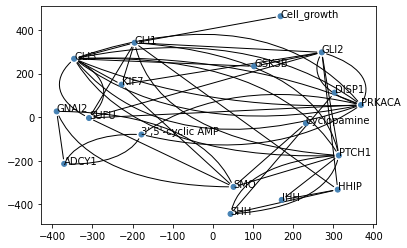

In [23]:
layout = igraph_layout_from_cx_cartesian_layout(g)
fig, ax = plt.subplots()
igraph.plot(g, layout=layout, target=ax, vertex_label=g.vs["name"])